In [1]:
import os
import numpy
from collections import *
import pandas as pd
import binascii
from PIL import Image
from IPython.display import display
import re
from random import *
import shutil

In [2]:
train_labels = "data/trainLabels.csv"
subtrain_labels = "data/subtrainLables.csv"
sample_number = 100
class_number = 9

# 0. Sampling the dataset
Our dataset is adopted from the Microsoft malware classification challenge (BIG 2015), which consists of 9 classes of malware: 
1. Ramnit
2. Lollipop
3. Kelihos_ver3
4. Vundo
5. Simda
6. Tracur
7. Kelihos_ver1
8. Obfuscator.ACY
9. Gatak

For each code sample, we have an ID (string), an .asm file (text), and a .bytes file (hex), and a label (1-9).

The original dataset is over 34GB even after compression and is overwhelming for our purpose. So we sample a subset of the original training set by randomly taking 10% samples out from each categary, and manually filtered out "bad" samples (whose .bytes files contains only "??". We expect such bad files to be extremely rare. We only encounter 1 bad file out of 1k+ samples during our sampling.)

In [ ]:
rs = Random()
trainlabels = pd.read_csv(train_labels)#labels in the original dataset
sample_ids = []
opd = pd.DataFrame()
for clabel in range (1,class_number+1):
    # select a category
    mids = trainlabels[trainlabels.Class == clabel]
    mids = mids.reset_index(drop=True)
    # randomly select 10% samples from a category
    rchoice = set()
    while len(rchoice) < len(mids)*sample_percentage:
        rchoice.add(rs.randint(0,len(mids)-1))
    rids = [mids.loc[i].Id for i in rchoice]
    print("randomly selected {} samples from class {}".format(len(rids), clabel))
    sample_ids.extend(rids)
    opd = opd.append(mids.loc[rchoice])
    
opd = opd.reset_index(drop=True)
# save sampled labels to file
opd.to_csv(subtrain_labels, encoding='utf-8', index=False)
print("subtrain sample ids saved to {}".format(subtrain_labels))

# copy selected samples from original dataset
source_base = 'data/train/'#source
destination_base = 'data/subtrain/'#destination
for sample_id in sample_ids:
    fnames = ['{0}.asm'.format(sample_id),'{0}.bytes'.format(sample_id)]
    for fname in fnames:
        copy_source_spath = source_base + fname
        copy_destination_path = destination_base + fname
        shutil.copy(copy_source_spath,copy_destination_path)
print("adopted training set generated at ./data/subtrain")

# 1. image features/coverting code to images
Rationale: To convert code sample (binary or in our case, .bytes/hex file) to an image, we treat each byte (ranging from 00 to FF) as a pixel (ranging from 0 to 255), and therefore get a greyscale image.

In [ ]:
# convert .bytes files to image matrices
def getMatrixfrom_hex(filename, width):
    arr = []
    with open(filename,'rb') as f:
        for line in f:
            # read in every byte and turn it into a hex number
            arr.extend(int(byte,16) for byte in line.split()[1:] if byte != b'??')
    height = int(len(arr)/width)
    arr = numpy.reshape(arr[:height*width],(height,width))
    arr = numpy.uint8(arr)
    print("matrix shape: ",arr.shape)
    return arr

In [ ]:
#save images to .png files
basepath = "data/subtrain/"
img_width=512
mapimg = defaultdict(list)
training_samples = pd.read_csv(subtrain_labels)
i = 0
for sample_id in training_samples.Id:
    i += 1
    print("dealing with {0}th file {1}...".format(str(i), sample_id))
    filename = basepath + sample_id + ".bytes"
    matrix = getMatrixfrom_hex(filename, img_width)
    mapimg[sample_id] = matrix
    im = Image.fromarray(matrix) #save images to .png files
    display(im)
    im.save(basepath+sample_id+".png")
print("images generated at .data/subtrain/")

Save images to .csv files.

It's weird. Commented out.

In [ ]:
# dataframelist = []
# for sample_id, matrix in mapimg.items():
#     standard = {}
#     standard["Id"] = sample_id
#     for index,value in enumerate(matrix):# value.shape=(img_width,) value是图像/矩阵的一行
#         colName = "line{0}".format(str(index))
#         standard[colName] = value
#     dataframelist.append(standard)

# df = pd.DataFrame(dataframelist)
# df.to_csv("imgfeature-frombytes-{0}.csv".format(img_width),index=False)
# print("image features saved to file")

# 2. op-code features
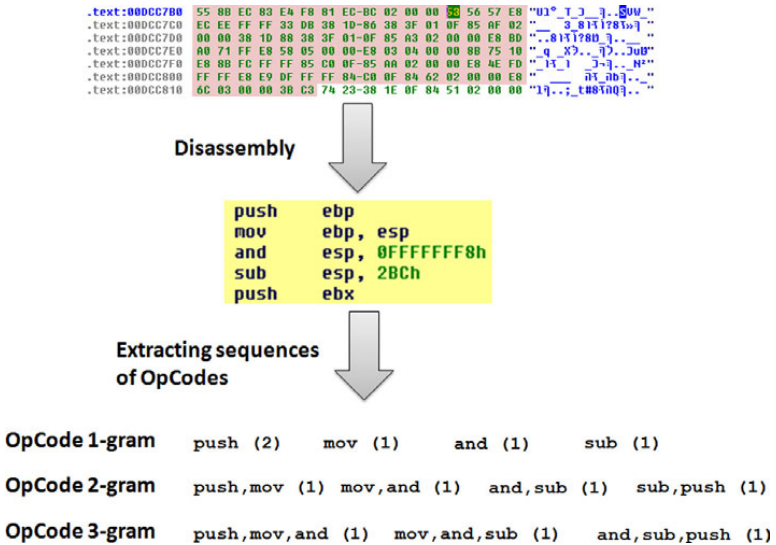

In [ ]:
# extract op-code from .asm files
def getOpcodeSequence(filename):
    opcode_seq = []
    p = re.compile(r'\s([a-fA-F0-9]{2}\s)+\s*([a-z]+)')
    with open(filename,  'r', encoding="ISO-8859-1") as f:
        for line in f:
            if line.startswith(".text"):
                m = re.findall(p,line)
                if m:
                    opc = m[0][1]
                    if opc != "align":
                        opcode_seq.append(opc)
    return opcode_seq

# turn opcode sequences into n-gram tuples
def getOpcodeNgram(ops, n=3):
    opngramlist = [tuple(ops[i:i+n]) for i in range(len(ops)-n)]
    opngram = Counter(opngramlist)
    return opngram

In [ ]:
basepath = "data/subtrain/"
n = 3
mapngram = defaultdict(Counter)
training_samples = pd.read_csv(subtrain_labels)
count = 1
for sample_id in training_samples.Id:
#     print(sample_id)
    print("counting the {1}-gram of the {0}th file...".format(str(count), n))
    count += 1
    filename = basepath + sample_id + ".asm"
    ops = getOpcodeSequence(filename)
    opngram = getOpcodeNgram(ops, n)
    mapngram[sample_id] = opngram

In [ ]:
count_threshold = 50
#calculate the count of an operation across asm files
total_count = Counter([]) 
for count in mapngram.values():
    total_count += count
selectedfeatures = {}

#filter out less frequent features
for feature,count in total_count.items():
    if count >= count_threshold:
        selectedfeatures[feature] = count 

#save n-gram op-code to file
dataframelist = []
for sample_id,opngram in mapngram.items():
    standard = {}
    standard["Id"] = sample_id
    for feature in selectedfeatures:
        if feature in opngram:
            standard[feature] = opngram[feature]
        else:
            standard[feature] = 0
    dataframelist.append(standard)
df = pd.DataFrame(dataframelist)
df.to_csv("{0}gramfeature.csv".format(n),index=False)
print("{0}-gram features generated".format(n))